# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [179]:
#pip install missingno

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', None) 

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

telecomdata = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(telecomdata.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [4]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Data Preprocessing
Handle missing data
Feature extraction
Identify correlation among predictors
Deal with categorical variable, convert them into numericals


In [5]:
# Cheking percentage of missing values in columns
telecomdata_missingvalue_perc = (round(((telecomdata.isnull().sum()/len(telecomdata.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
telecomdata_missingvalue_perc

null
arpu_3g_6                 74.9
count_rech_2g_6           74.9
night_pck_user_6          74.9
arpu_2g_6                 74.9
date_of_last_rech_data_6  74.9
...                        ...
last_day_rch_amt_8         0.0
vol_2g_mb_6                0.0
vol_2g_mb_7                0.0
vol_2g_mb_8                0.0
churn_probability          0.0

[172 rows x 1 columns]

In [8]:
# List the columns having more than 50% missing values
col_list_50perc_missing = list(telecomdata_missingvalue_perc.index[telecomdata_missingvalue_perc['null'] > 70])
col_list_50perc_missing

['arpu_3g_6',
 'count_rech_2g_6',
 'night_pck_user_6',
 'arpu_2g_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'av_rech_amt_data_6',
 'max_rech_data_6',
 'count_rech_3g_6',
 'fb_user_6',
 'night_pck_user_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'fb_user_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'arpu_3g_7',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'count_rech_2g_8',
 'av_rech_amt_data_8',
 'night_pck_user_8',
 'max_rech_data_8',
 'total_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'count_rech_3g_8']

There is no much value addition for the columns missing more than 50% of values. Treat them as if they do not exist.

In [9]:
# Delete the columns having more than 50% missing values
telecomdata_curated = telecomdata.drop(col_list_50perc_missing, axis=1)

In [10]:
telecomdata_curated.shape

(69999, 142)

In [13]:
#telecomdata_curated['churn_probability'].describe()

Drop Date columns

In [12]:
# List the date columns
date_cols = [k for k in telecomdata.columns.to_list() if 'date' in k]
print(date_cols) 
# Dropping date columns
telecomdata_curated = telecomdata.drop(date_cols, axis=1)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


In [14]:
# Drop circle_id column as it is an unique identifier
telecomdata_curated = telecomdata_curated.drop('circle_id', axis=1)

In [15]:

telecomdata_curated.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou   arpu_6   arpu_7  \
0   0             0.0             0.0             0.0   31.277   87.009   
1   1             0.0             0.0             0.0    0.000  122.787   
2   2             0.0             0.0             0.0   60.806  103.176   
3   3             0.0             0.0             0.0  156.362  205.260   
4   4             0.0             0.0             0.0  240.708  128.191   

    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0    7.527        48.58       124.38         1.29         32.24         96.68   
1   42.953         0.00         0.00         0.00          0.00         25.99   
2    0.000         0.53        15.93         0.00         53.99         82.05   
3  111.095         7.26        16.01         0.00         68.76         78.48   
4  101.565        21.28         4.83         6.13         56.99         38.11   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          2.33           0.00            0.0            0.0           0.00   
1         30.89           0.00            0.0            0.0           0.00   
2          0.00           0.00            0.0            0.0           0.00   
3         50.23           0.00            0.0            0.0           0.00   
4          9.63          53.64            0.0            0.0          15.73   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0           0.00              2.23              0.00   
1            0.0           0.00              0.00              0.00   
2            0.0           0.00              0.53             12.98   
3            0.0           1.63              6.99              3.94   
4            0.0           0.00             10.16              4.83   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              0.28              5.29             16.04              2.33   
1              0.00              0.00              0.00              0.00   
2              0.00             24.11              0.00              0.00   
3              0.00             37.91             44.89             23.63   
4              6.13             36.74             19.88              4.61   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              2.14   
3              0.00              0.00              0.00              0.00   
4             11.99              1.23              5.01              0.00   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.00          7.53         16.04   
1             22.01             29.79          0.00          0.00   
2              0.00              0.00         24.64         12.98   
3              0.00              8.03         44.91         48.84   
4              9.85              0.00         58.91         25.94   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0          2.61             46.34            124.38              1.01   
1          0.00              0.00              0.00              0.00   
2          0.00              0.00              2.94              0.00   
3         23.63              0.26             12.06              0.00   
4         15.76              0.00              0.00              0.00   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             18.75             80.61               0.0              0.00   
1              0.00              0.00               0.0              0.00   
2             28.94             82.05               0.0              0.00   
3             15.33             25.93               4.6              0.56  

Let's look at each variable's datatype:

In [16]:
telecomdata_curated.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 162 columns):
 #    Column              Dtype  
---   ------              -----  
 0    id                  int64  
 1    loc_og_t2o_mou      float64
 2    std_og_t2o_mou      float64
 3    loc_ic_t2o_mou      float64
 4    arpu_6              float64
 5    arpu_7              float64
 6    arpu_8              float64
 7    onnet_mou_6         float64
 8    onnet_mou_7         float64
 9    onnet_mou_8         float64
 10   offnet_mou_6        float64
 11   offnet_mou_7        float64
 12   offnet_mou_8        float64
 13   roam_ic_mou_6       float64
 14   roam_ic_mou_7       float64
 15   roam_ic_mou_8       float64
 16   roam_og_mou_6       float64
 17   roam_og_mou_7       float64
 18   roam_og_mou_8       float64
 19   loc_og_t2t_mou_6    float64
 20   loc_og_t2t_mou_7    float64
 21   loc_og_t2t_mou_8    float64
 22   loc_og_t2m_mou_6    float64
 23   loc_og_t2m_mou_7    float64
 24   

Let's also summarize the features using the df.describe method:

In [196]:
telecomdata_curated.describe(include="all")

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count  69999.000000         69297.0         69297.0         69297.0   
mean   34999.000000             0.0             0.0             0.0   
std    20207.115084             0.0             0.0             0.0   
min        0.000000             0.0             0.0             0.0   
25%    17499.500000             0.0             0.0             0.0   
50%    34999.000000             0.0             0.0             0.0   
75%    52498.500000             0.0             0.0             0.0   
max    69998.000000             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000          1.610000   
50%         0.000000         11.910000         11.580000         11.740000   
75%         0.000000         40.740000         39.760000         39.895000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      67231.000000      67312.000000      66296.000000      67231.000000   
mean          93.238231         90.799240         91.121447          3.743179   
std          162.046699        153.852597        152.997805         13.319542   
min            0.000000          0.000000          0.000000          0.000000   
25%            9.920000         10.090000          9.830000          0.000000   
50%           41.030000         40.170000         40.350000          0.000000   
75%          110.430000        107.540000        109

In [197]:
# create churn variable: those who have not used either calls or internet in the month of August (last month) are customers who have churned

# 0 - not churn, 1 - churn

In [198]:
#telecomdata_curated['churn'] = np.where((telecomdata_curated['total_ic_mou_8']==0) & (telecomdata_curated['total_og_mou_8']==0) & (telecomdata_curated['vol_2g_mb_8']==0) & (telecomdata_curated['vol_3g_mb_8']==0), 1, 0)

In [199]:
telecomdata_curated.shape

(69999, 162)

In [200]:
telecomdata_curated.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 162 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    id                  69999 non-null  int64  
 1    loc_og_t2o_mou      69297 non-null  float64
 2    std_og_t2o_mou      69297 non-null  float64
 3    loc_ic_t2o_mou      69297 non-null  float64
 4    arpu_6              69999 non-null  float64
 5    arpu_7              69999 non-null  float64
 6    arpu_8              69999 non-null  float64
 7    onnet_mou_6         67231 non-null  float64
 8    onnet_mou_7         67312 non-null  float64
 9    onnet_mou_8         66296 non-null  float64
 10   offnet_mou_6        67231 non-null  float64
 11   offnet_mou_7        67312 non-null  float64
 12   offnet_mou_8        66296 non-null  float64
 13   roam_ic_mou_6       67231 non-null  float64
 14   roam_ic_mou_7       67312 non-null  float64
 15   roam_ic_mou_8       66296 non-null

In [201]:
# List only the numeric columns
#numeric_cols = telecomdata_curated.select_dtypes(exclude=['object']).columns
#print(numeric_cols)

In [202]:
"""
# Removing outliers below 10th and above 90th percentile
for col in numeric_cols: 
    q1 = telecomdata_curated[col].quantile(0.10)
    q3 = telecomdata_curated[col].quantile(0.90)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    print(range_low,range_high)
    # Assigning the filtered dataset into data
    data = telecomdata_curated.loc[(telecomdata_curated[col] > range_low) & (telecomdata_curated[col] < range_high)]

data.shape
"""

'\n# Removing outliers below 10th and above 90th percentile\nfor col in numeric_cols: \n    q1 = telecomdata_curated[col].quantile(0.10)\n    q3 = telecomdata_curated[col].quantile(0.90)\n    iqr = q3-q1\n    range_low  = q1-1.5*iqr\n    range_high = q3+1.5*iqr\n    print(range_low,range_high)\n    # Assigning the filtered dataset into data\n    data = telecomdata_curated.loc[(telecomdata_curated[col] > range_low) & (telecomdata_curated[col] < range_high)]\n\ndata.shape\n'

In [17]:
# Count the ROWS having more than 50% missing values
df_missing_rows_50 = telecomdata_curated[(telecomdata_curated.isnull().sum(axis=1)) > (len(telecomdata_curated.columns)//2)]
df_missing_rows_50.shape
# Deleting the ROWS having more than 50% missing values
telecomdata_curated = telecomdata_curated.drop(df_missing_rows_50.index)
telecomdata_curated.shape

(68252, 162)

In [18]:
missing_data_percent = telecomdata_curated.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6',
       ...
       'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8'],
      dtype='object', length=114)

In [19]:
imp = SimpleImputer(strategy='constant', fill_value=0)
telecomdata_curated[impute_cols] = imp.fit_transform(telecomdata_curated[impute_cols])

In [21]:
#This list contains column names that are identified as categorical columns.
cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]
numerical_cols = [col for col in telecomdata_curated.columns if col not in  cat_cols]

In [22]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
telecomdata_curated[cat_cols] = telecomdata_curated[cat_cols].fillna(-1).astype('category')
print(telecomdata_curated[cat_cols].isnull().sum()*100/telecomdata_curated.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


- **Replacing NaN Values in Categorical Columns: The objection proposes replacing NaN values in categorical-related columns with -1 in the test set.**
- **Data Type Mismatch: It's observed that the columns listed in cat_cols are of the float64 data type, which should ideally be converted to the category data type to ensure consistency and accuracy in data representation.**

In [23]:
## Identify high value customers

In [24]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
telecomdata_curated['total_rech_data_amt_6'] = telecomdata_curated['total_rech_data_6'] * telecomdata_curated['av_rech_amt_data_6']
telecomdata_curated['total_rech_data_amt_7'] = telecomdata_curated['total_rech_data_7'] * telecomdata_curated['av_rech_amt_data_7']

telecomdata_curated['total_amt_6'] = telecomdata_curated['total_rech_data_amt_6'] + telecomdata_curated['total_rech_amt_6']
telecomdata_curated['total_amt_7'] = telecomdata_curated['total_rech_data_amt_7'] + telecomdata_curated['total_rech_amt_7']

telecomdata_curated['total_avg_amt_6_7'] = telecomdata_curated[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [25]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecomdata_curated.drop(drop_data_cols, axis=1, inplace=True)

In [26]:
telecomdata_curated.shape

(68252, 159)

In [27]:
cutoff = telecomdata_curated['total_avg_amt_6_7'].quantile(0.7)
cutoff

484.0

In [28]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
highprofit_custdata = telecomdata_curated[(telecomdata_curated['total_avg_amt_6_7'] > cutoff)].copy()

print(highprofit_custdata.shape)

(20467, 159)


Target variable

In [29]:
# check data type of target variable
highprofit_custdata['churn_probability'].dtype

dtype('int64')

In [30]:
# Changing data type int64 to category
highprofit_custdata['churn_probability'] = highprofit_custdata['churn_probability'].astype('category')

In [31]:
# analysing churn and not-churn
highprofit_custdata['churn_probability'].value_counts()

churn_probability
0    18871
1     1596
Name: count, dtype: int64

In [33]:
# analysing churn and not-churn
highprofit_custdata['churn_probability'].value_counts()*100 /highprofit_custdata.shape[0]

churn_probability
0    92.202081
1     7.797919
Name: count, dtype: float64

- **92.2% of customers are non-churned, while 7.79% of customers are churned.**

In [61]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(highprofit_custdata[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [62]:
final_df = pd.concat([highprofit_custdata, dummy_df], axis=1)

In [63]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [64]:
final_df.shape

(20467, 159)

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [72]:
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']
X.shape, y.shape

((20467, 158), (20467,))

Splitting train and test data to avoid any contamination of the test data

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16373, 158), (4094, 158), (16373,), (4094,))

In [74]:
X_train.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou   arpu_6  \
12202  12202             0.0             0.0             0.0  492.380   
30803  30803             0.0             0.0             0.0  298.601   
60803  60803             0.0             0.0             0.0  696.491   
43189  43189             0.0             0.0             0.0  618.109   
80        80             0.0             0.0             0.0  384.180   

        arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
12202  594.251  484.413        84.86        36.54        51.81        765.28   
30803  141.200  352.971       778.93       163.43        43.08        104.06   
60803  615.788  307.430       143.34        27.64        86.33        142.21   
43189  445.357  640.733        20.94         9.89        10.11        126.56   
80     500.546  485.113        13.33         6.24         6.41        291.26   

       offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
12202       1060.99        866.83           0.00            0.0   
30803         31.18        253.18           0.00            0.0   
60803         27.19         27.68           1.36            0.0   
43189         22.43         77.88           0.00            0.0   
80           267.39        310.41           0.00            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
12202           0.00           0.00            0.0           0.00   
30803           0.00           0.00            0.0           0.00   
60803          29.18           9.61            0.0          74.31   
43189           0.00           0.00            0.0           0.00   
80              0.00           0.00            0.0           0.00   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
12202              7.14              2.28              0.00              2.19   
30803            778.93            163.43             43.08            102.24   
60803             21.71              5.96             13.18             62.54   
43189             18.93              9.14              9.58             90.34   
80                13.33              5.83              6.41            277.46   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
12202              9.08              0.35              0.00              0.00   
30803             30.89            246.91              0.23              0.00   
60803             10.99              1.71              0.00              0.00   
43189             21.36             71.06             19.59              1.06   
80               262.99            300.28              0.85              1.71   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
12202              0.00              0.00              0.00              0.00   
30803              1.31              0.00              0.00              0.00   
60803              0.00              2.63              8.84              0.00   
43189              6.81              0.00              0.00              0.00   
80                 0.91              0.00              0.00              6.35   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
12202          9.34         11.36          0.35             77.71   
30803        881.41        194.33        291.31              0.00   
60803         84.26         16.96         14.89            117.06   
43189        128.88         31.58         87.46              0.00   
80           291.64        270.54        307.61              0.00   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
12202             34.26             51.81            762.96           1051.91   
30803              0.00              0.00              1.58              0.28   
60803             21.68             19.06             74.16              0.00   
43189              0.75              0.53              7.56             

In [75]:
X_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 16373 entries, 12202 to 10186
Data columns (total 158 columns):
 #    Column                Dtype  
---   ------                -----  
 0    id                    int64  
 1    loc_og_t2o_mou        float64
 2    std_og_t2o_mou        float64
 3    loc_ic_t2o_mou        float64
 4    arpu_6                float64
 5    arpu_7                float64
 6    arpu_8                float64
 7    onnet_mou_6           float64
 8    onnet_mou_7           float64
 9    onnet_mou_8           float64
 10   offnet_mou_6          float64
 11   offnet_mou_7          float64
 12   offnet_mou_8          float64
 13   roam_ic_mou_6         float64
 14   roam_ic_mou_7         float64
 15   roam_ic_mou_8         float64
 16   roam_og_mou_6         float64
 17   roam_og_mou_7         float64
 18   roam_og_mou_8         float64
 19   loc_og_t2t_mou_6      float64
 20   loc_og_t2t_mou_7      float64
 21   loc_og_t2t_mou_8      float64
 22   loc_og_t2m_mou_6     

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

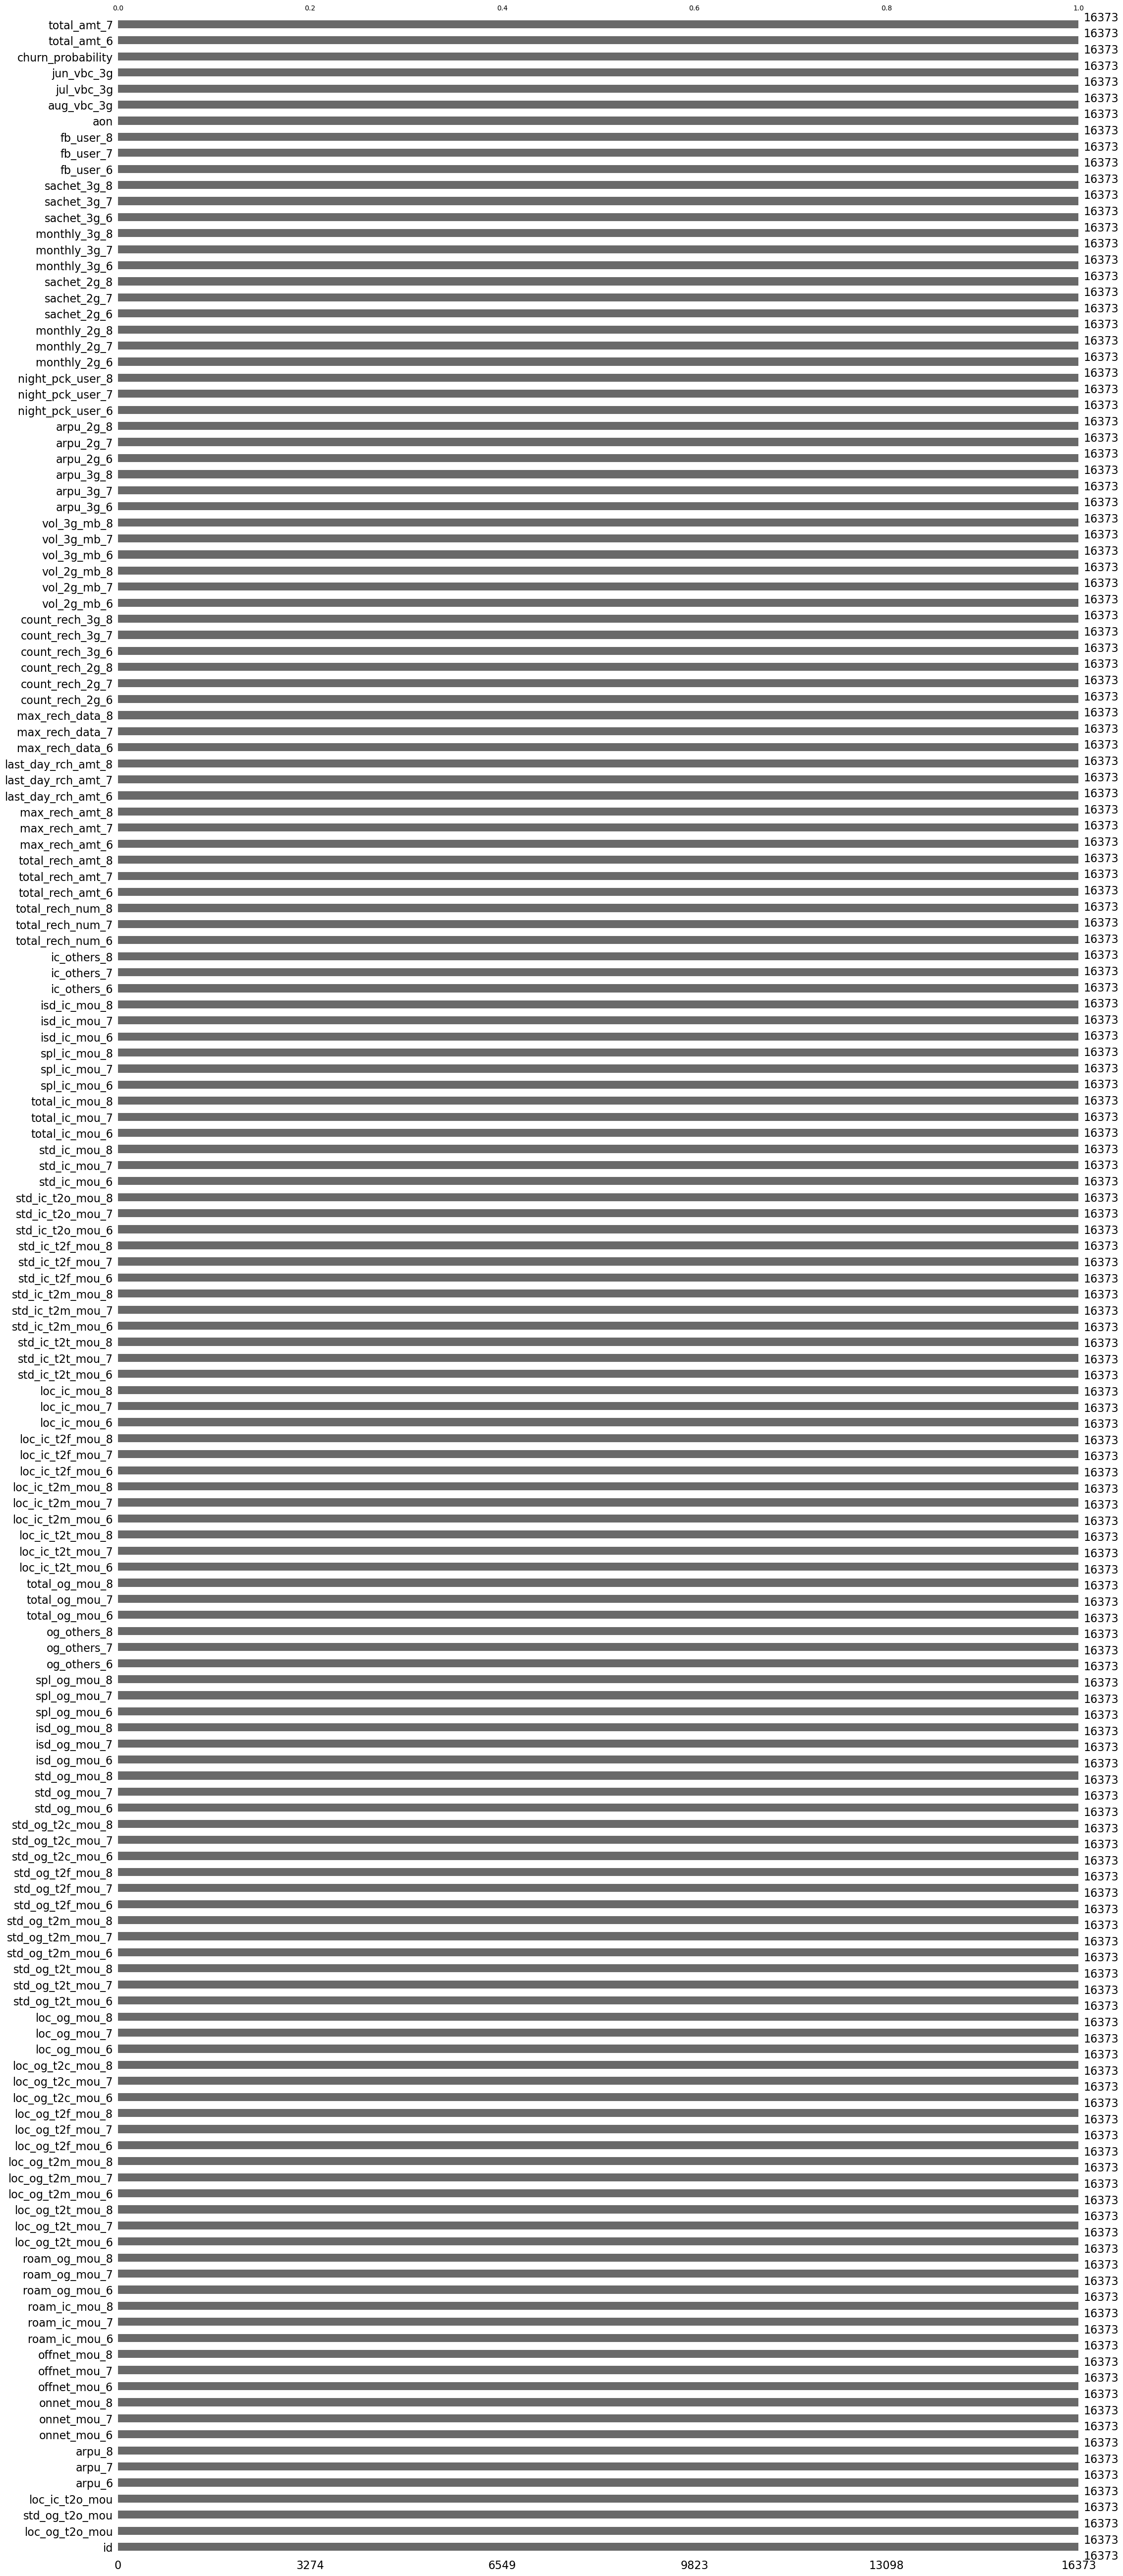

In [37]:
msno.bar(X_train)

<Axes: >

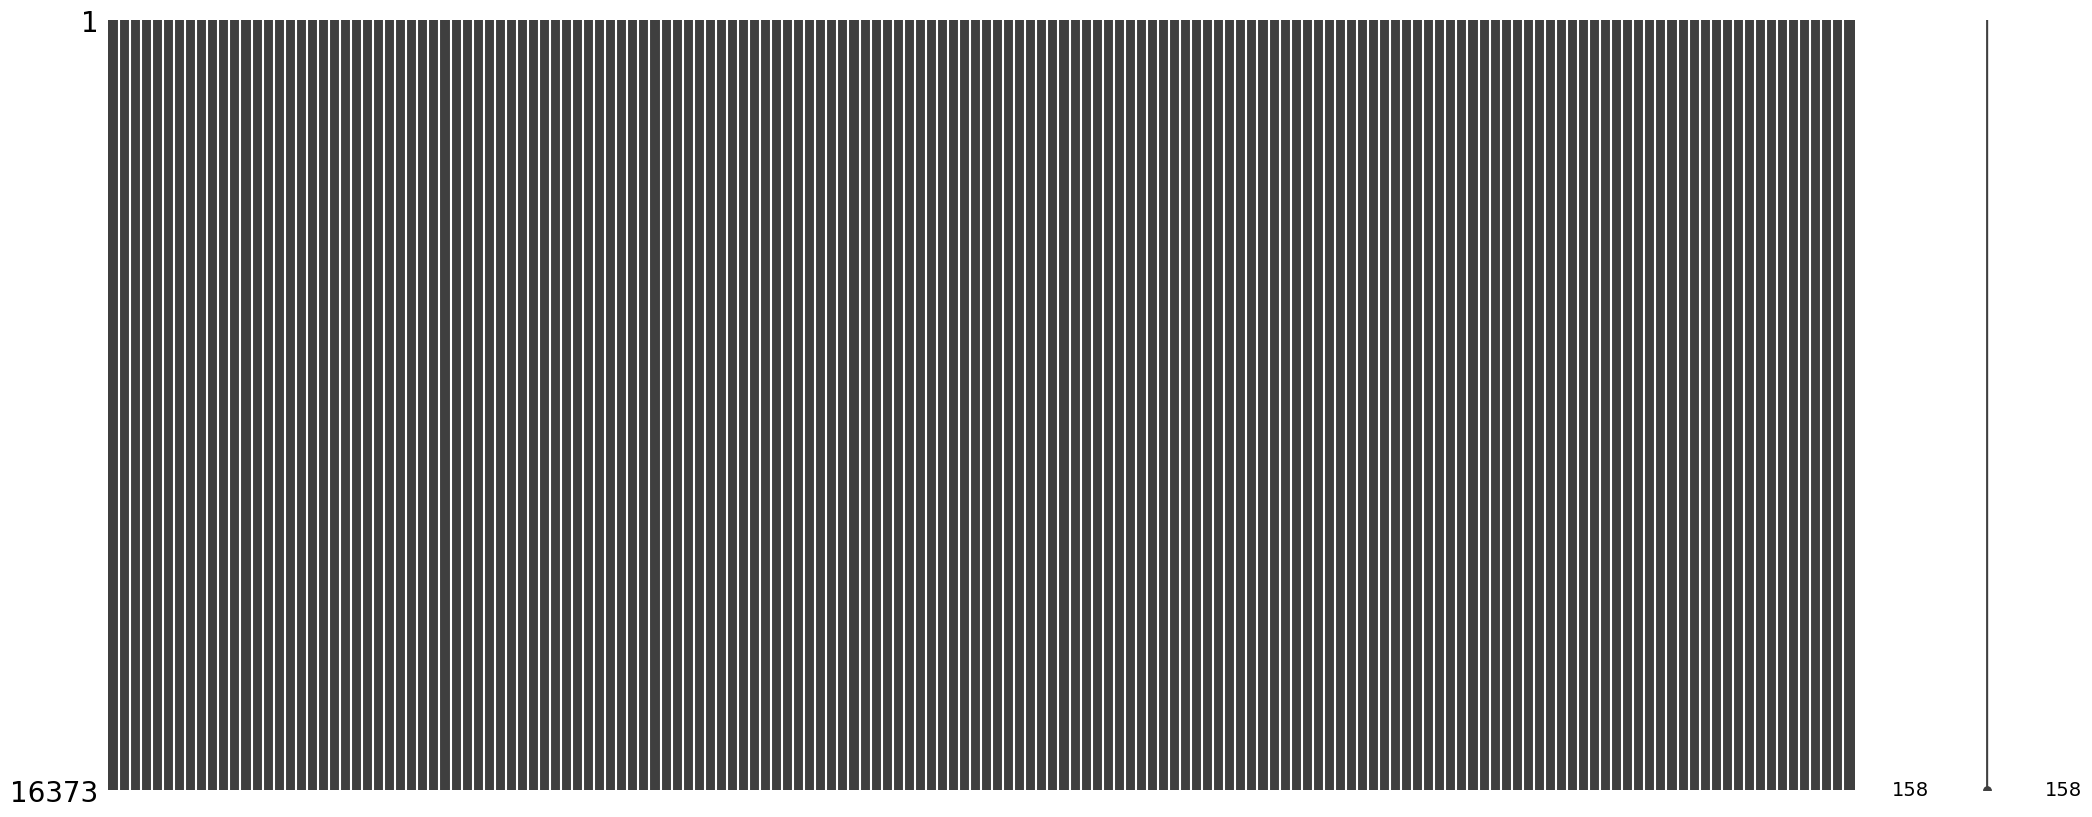

In [38]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [76]:
X_train_filtered = X_train
X_train_filtered.shape

(16373, 158)

In [50]:
X_train_filtered.describe(include="all")

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count   16373.000000         16373.0         16373.0         16373.0   
unique           NaN             NaN             NaN             NaN   
top              NaN             NaN             NaN             NaN   
freq             NaN             NaN             NaN             NaN   
mean    35013.706346             0.0             0.0             0.0   
std     20195.460128             0.0             0.0             0.0   
min         4.000000             0.0             0.0             0.0   
25%     17690.000000             0.0             0.0             0.0   
50%     34984.000000             0.0             0.0             0.0   
75%     52393.000000             0.0             0.0             0.0   
max     69997.000000             0.0             0.0             0.0   

              arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count   16373.000000  16373.000000  16373.000000  16373.000000  16373.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      564.546588    568.559664    516.051693    265.979588    270.668215   
std       488.018292    525.993606    550.617889    470.996623    487.576962   
min     -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       310.218000    313.372000    236.821000     18.140000     17.030000   
50%       487.102000    485.698000    432.710000     86.960000     84.910000   
75%       706.459000    704.026000    665.053000    294.930000    291.580000   
max     27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

         onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count   16373.000000  16373.000000  16373.000000  16373.000000   16373.000000   
unique           NaN           NaN           NaN           NaN            NaN   
top              NaN           NaN           NaN           NaN            NaN   
freq             NaN           NaN           NaN           NaN            NaN   
mean      238.057959    382.025259    385.848537    339.454540      16.297512   
std       466.997496    487.854805    503.192073    472.499164      80.044794   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        11.540000     75.790000     73.740000     51.490000       0.000000   
50%        67.980000    229.930000    225.690000    188.540000       0.000000   
75%       242.810000    496.740000    502.660000    443.040000       0.000000   
max     10752.560000   8362.360000   7043.980000   7857.780000    2613.310000   

        roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count    16373.000000   16373.000000   16373.000000   16373.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean        13.280790      12.482904      27.634650      20.552021   
std         82.158154      77.523109     122.999117      97.490090   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max       3813.290000    4169.810000    3775.110000    2812.040000   

        roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count    16373.000000      16373.000000      16373.000000      16373.000000   
unique            NaN               NaN               NaN               NaN   
top               NaN               NaN               NaN               NaN   
freq              NaN               NaN               NaN     

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

<Axes: >

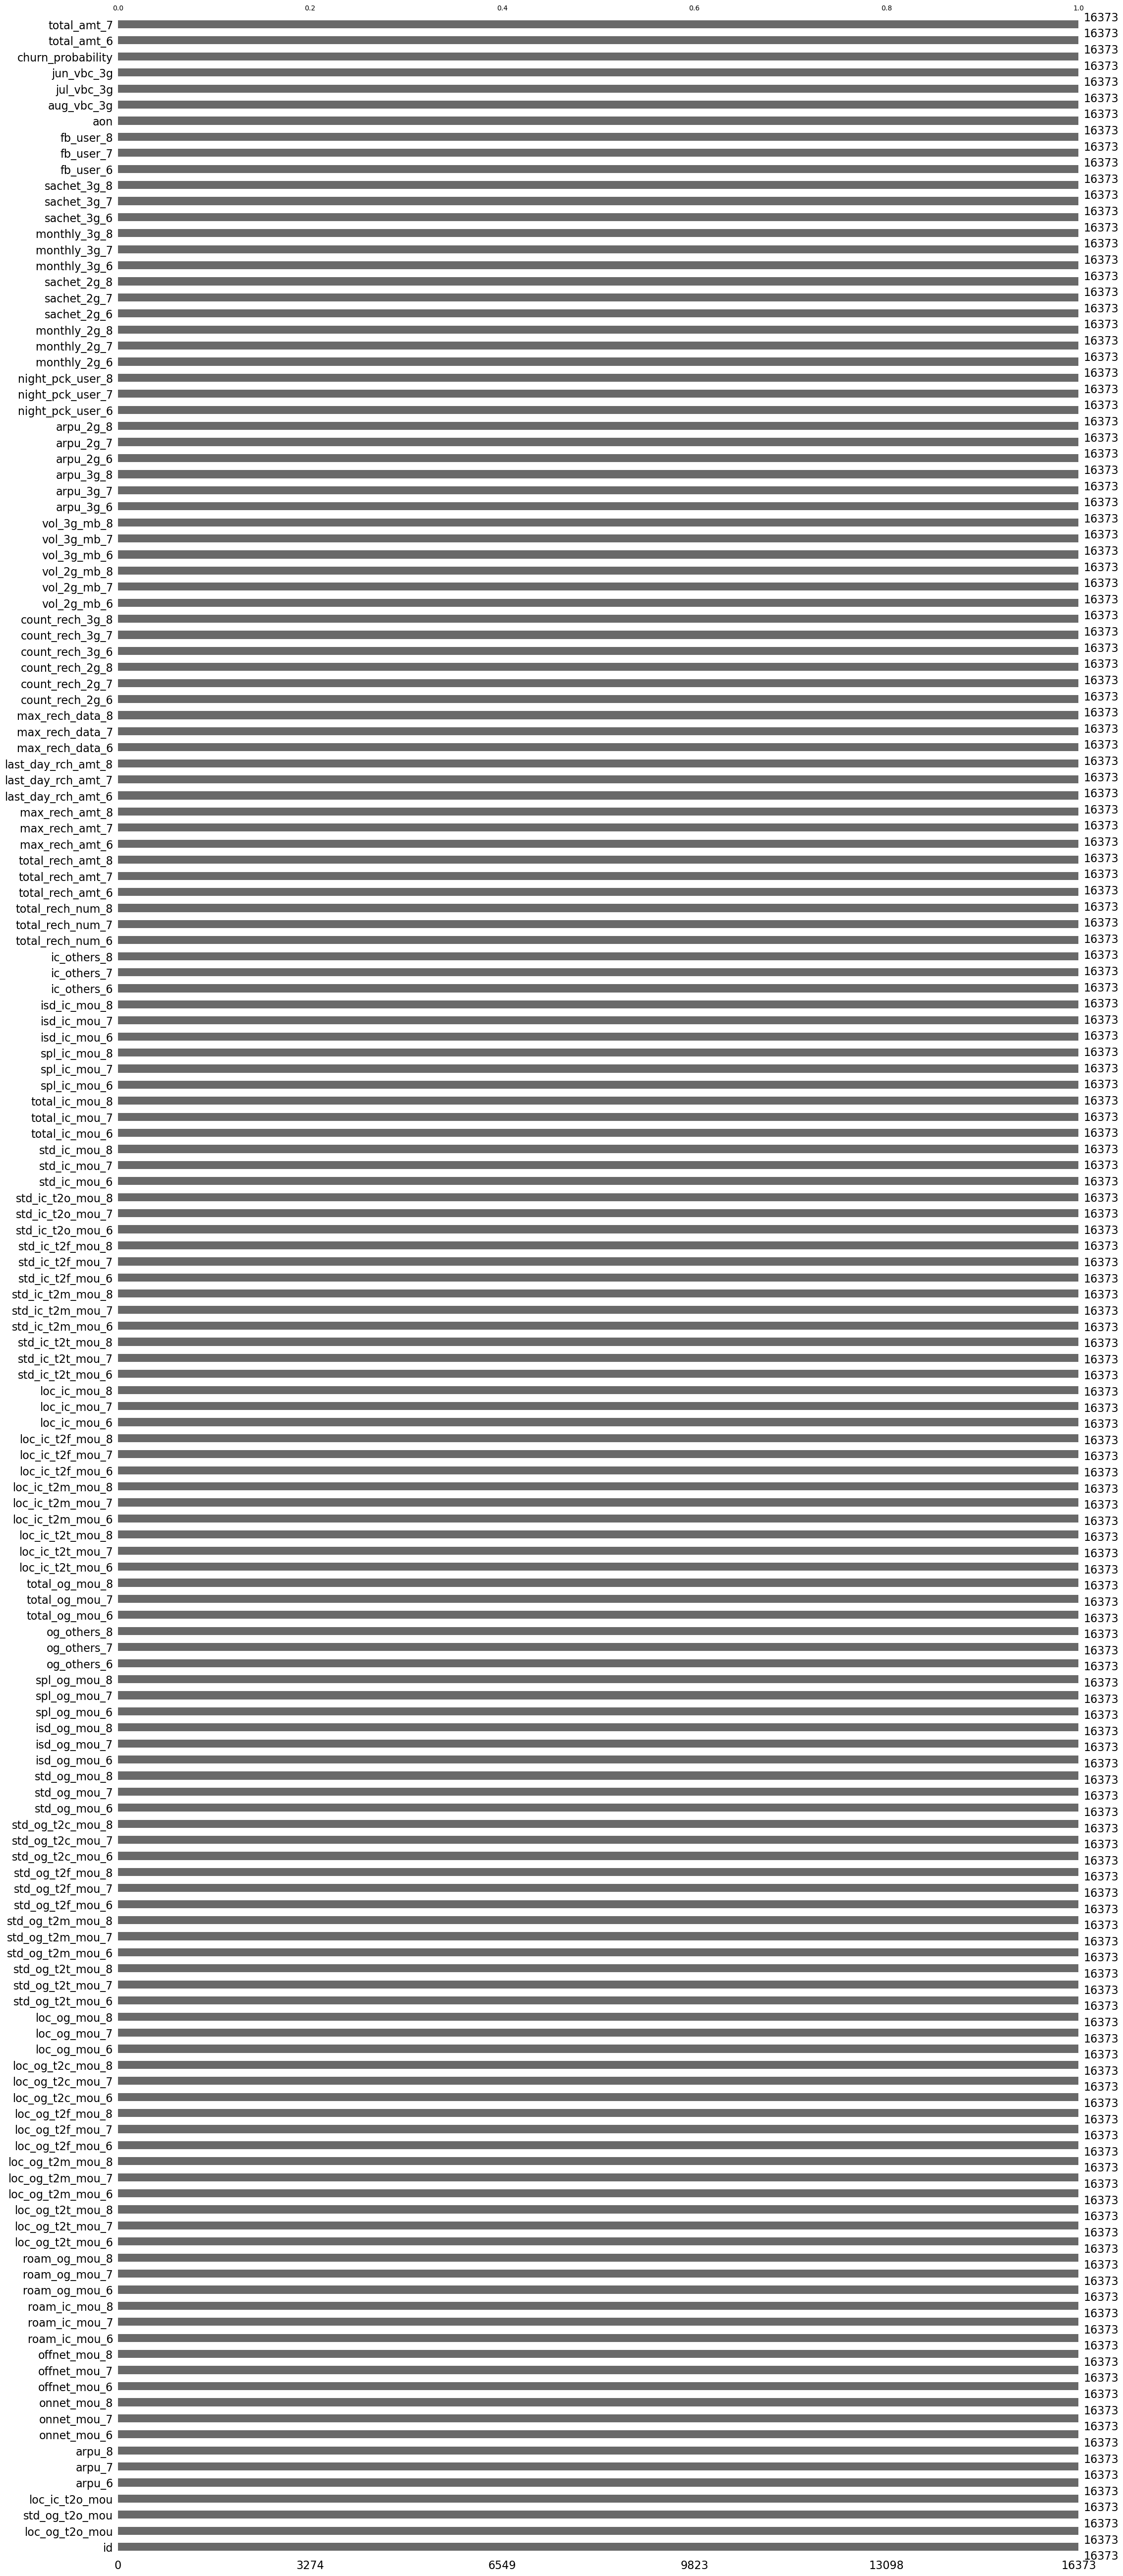

In [51]:
msno.bar(X_train_filtered)

In [52]:
X_train_filtered.describe()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count  16373.000000         16373.0         16373.0         16373.0   
mean   35013.706346             0.0             0.0             0.0   
std    20195.460128             0.0             0.0             0.0   
min        4.000000             0.0             0.0             0.0   
25%    17690.000000             0.0             0.0             0.0   
50%    34984.000000             0.0             0.0             0.0   
75%    52393.000000             0.0             0.0             0.0   
max    69997.000000             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  16373.000000  16373.000000  16373.000000  16373.000000  16373.000000   
mean     564.546588    568.559664    516.051693    265.979588    270.668215   
std      488.018292    525.993606    550.617889    470.996623    487.576962   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%      310.218000    313.372000    236.821000     18.140000     17.030000   
50%      487.102000    485.698000    432.710000     86.960000     84.910000   
75%      706.459000    704.026000    665.053000    294.930000    291.580000   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  16373.000000  16373.000000  16373.000000  16373.000000   16373.000000   
mean     238.057959    382.025259    385.848537    339.454540      16.297512   
std      466.997496    487.854805    503.192073    472.499164      80.044794   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%       11.540000     75.790000     73.740000     51.490000       0.000000   
50%       67.980000    229.930000    225.690000    188.540000       0.000000   
75%      242.810000    496.740000    502.660000    443.040000       0.000000   
max    10752.560000   8362.360000   7043.980000   7857.780000    2613.310000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   16373.000000   16373.000000   16373.000000   16373.000000   
mean       13.280790      12.482904      27.634650      20.552021   
std        82.158154      77.523109     122.999117      97.490090   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      3813.290000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   16373.000000      16373.000000      16373.000000      16373.000000   
mean       19.642690         85.225132         86.482882         79.229464   
std       107.341985        234.295074        244.350177        230.629443   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          4.730000          5.040000          2.930000   
50%         0.000000         25.430000         25.280000         21.460000   
75%         0.000000         79.160000         80.280000         73.160000   
max      5337.040000       6431.330000       6371.980000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      16373.000000      16373.000000      16373.000000      16373.000000   
mean         165.649185        164.236826        152.369056          6.374411   
std          252.704498        237.935319        229.126484         20.412999   
min            0.000000          0.000000          0.000000          0.000000   
25%           20.260000         21.680000         14.660000          0.000000   
50%           79.690000         81.280000         70.410000          0.080000   
75%          210.730000        210.180000        200

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [217]:
# Converting churn column to int in order to do aggfunc in the pivot table
#X_train_filtered['churn'] = X_train_filtered['churn'].astype('int64')

In [218]:
#X_train_filtered.pivot_table(values='churn', index='decrease_mou_action', aggfunc='mean').plot.bar()
#plt.ylabel('churn rate')
#plt.show()

<Axes: >

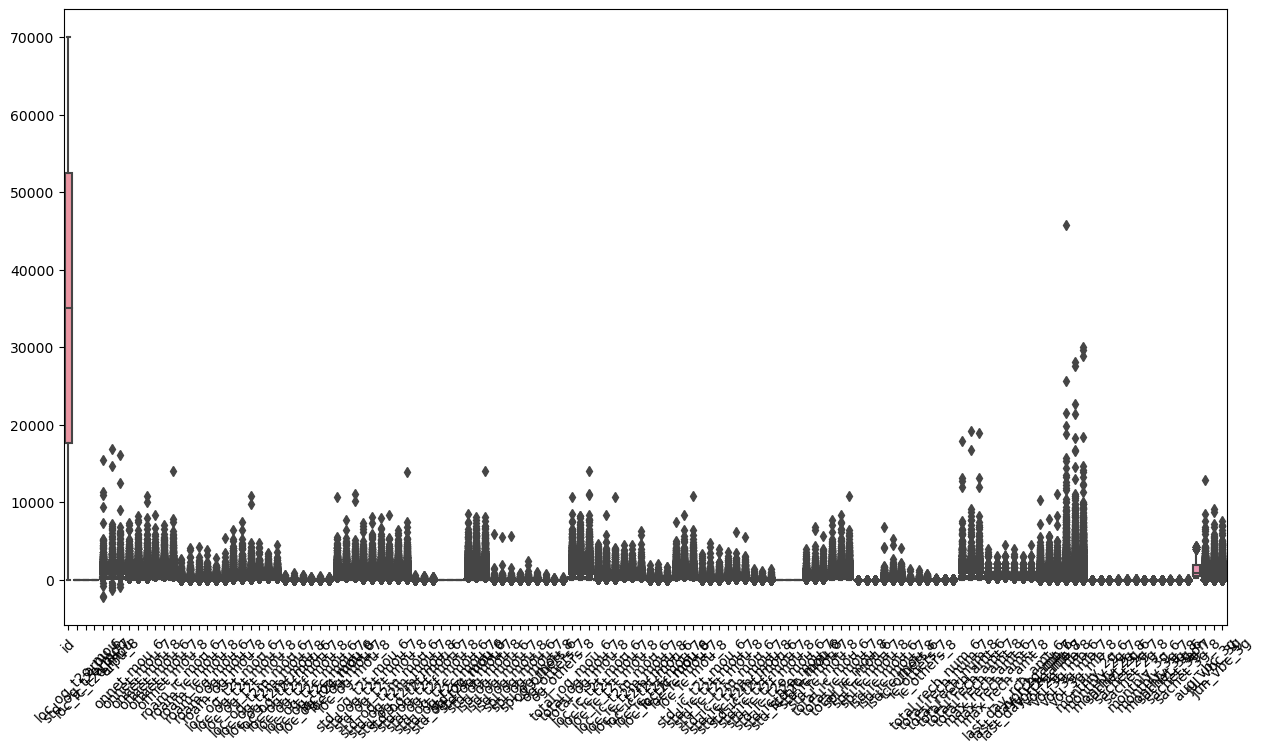

In [219]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [77]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

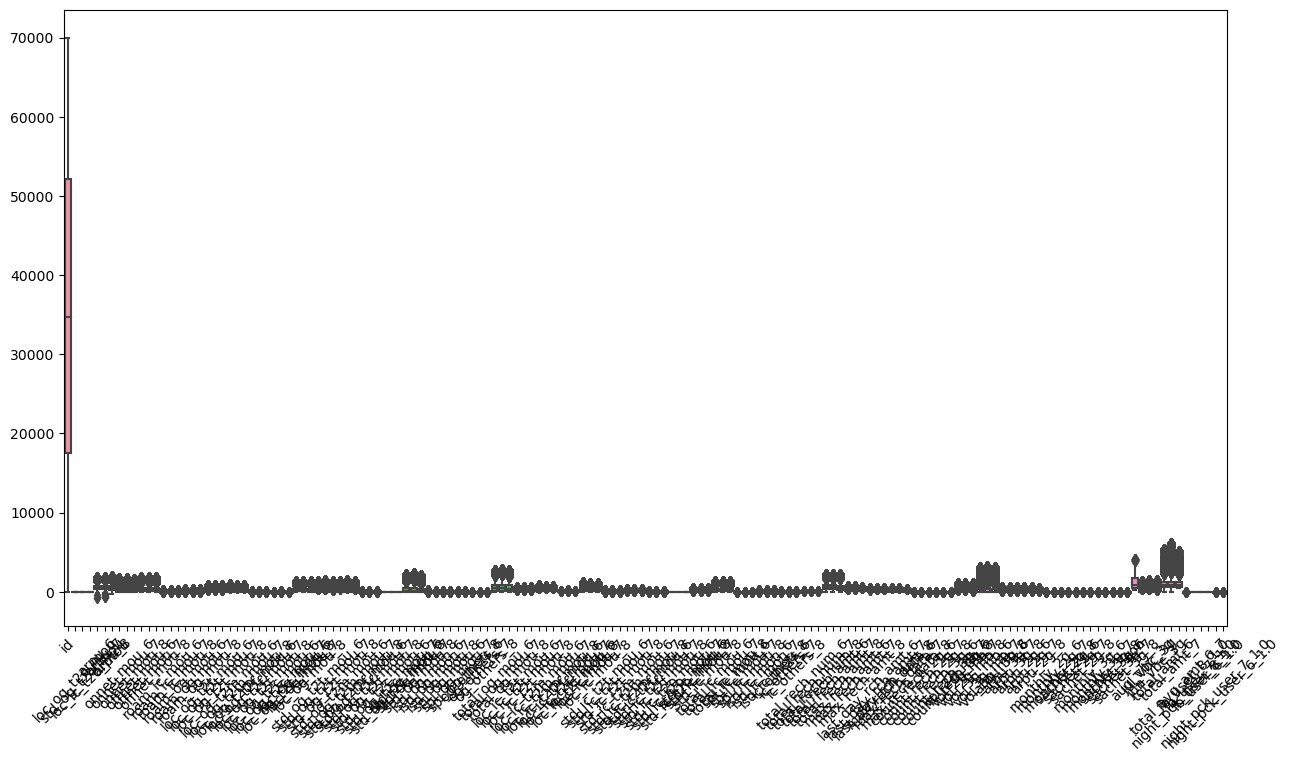

In [78]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [79]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered)

<Axes: >

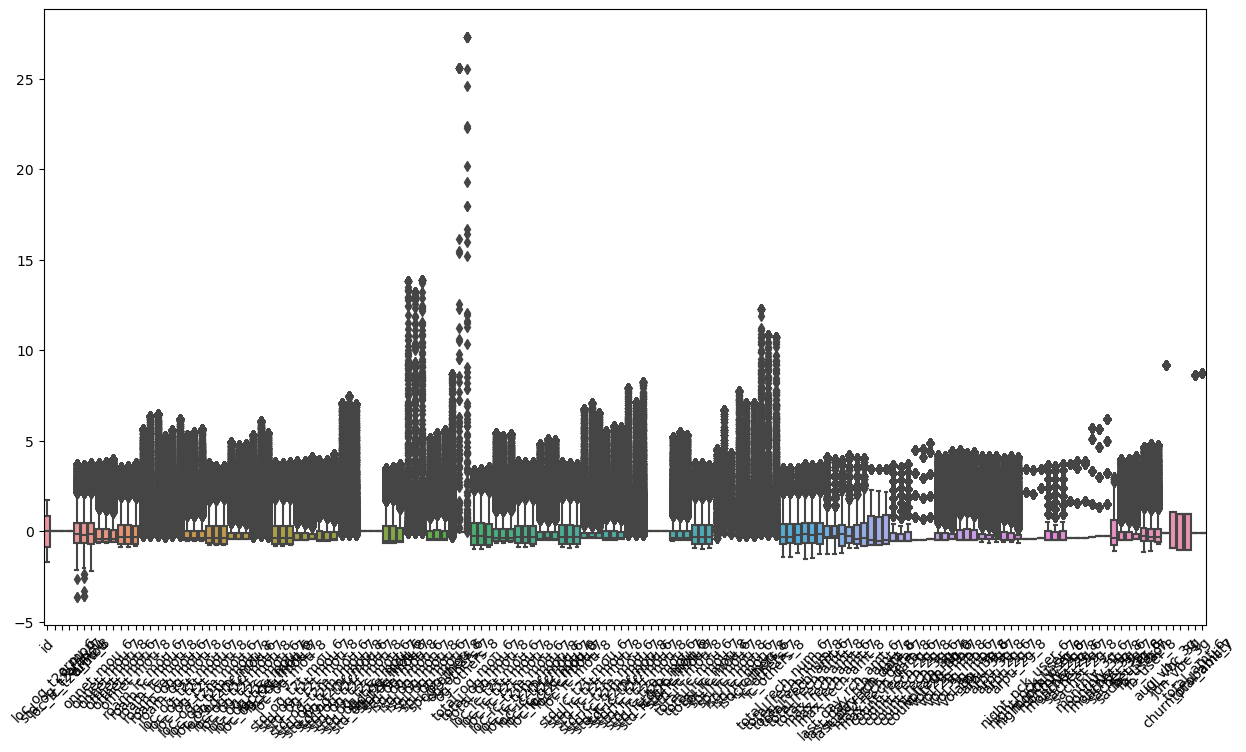

In [80]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

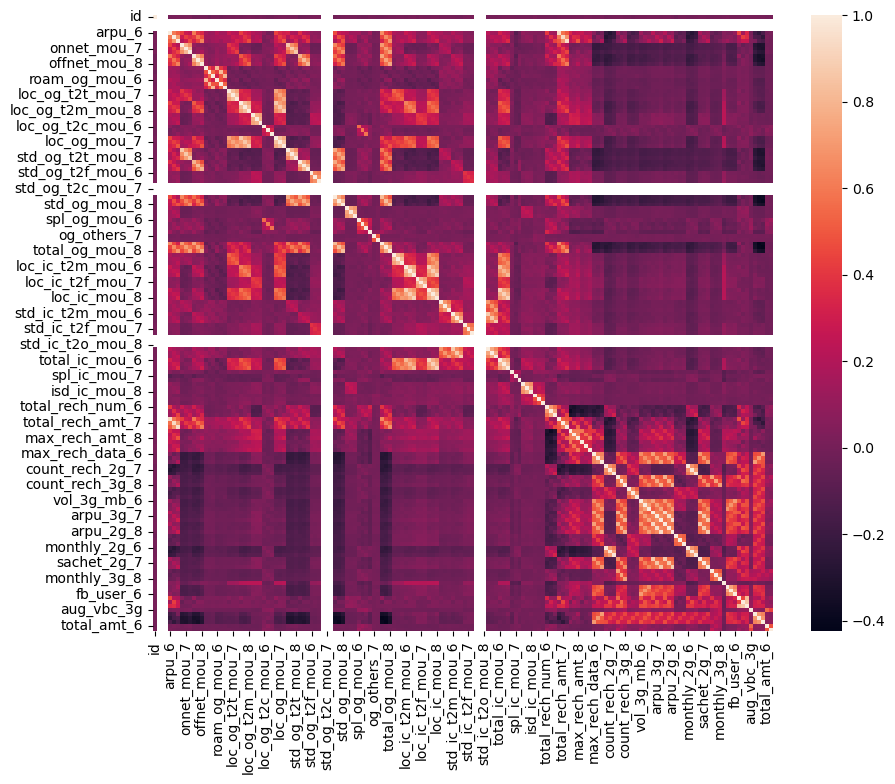

In [81]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

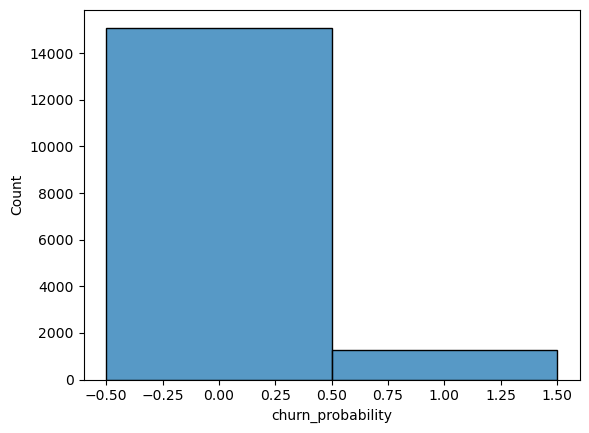

In [82]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [83]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [84]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 158 artists>

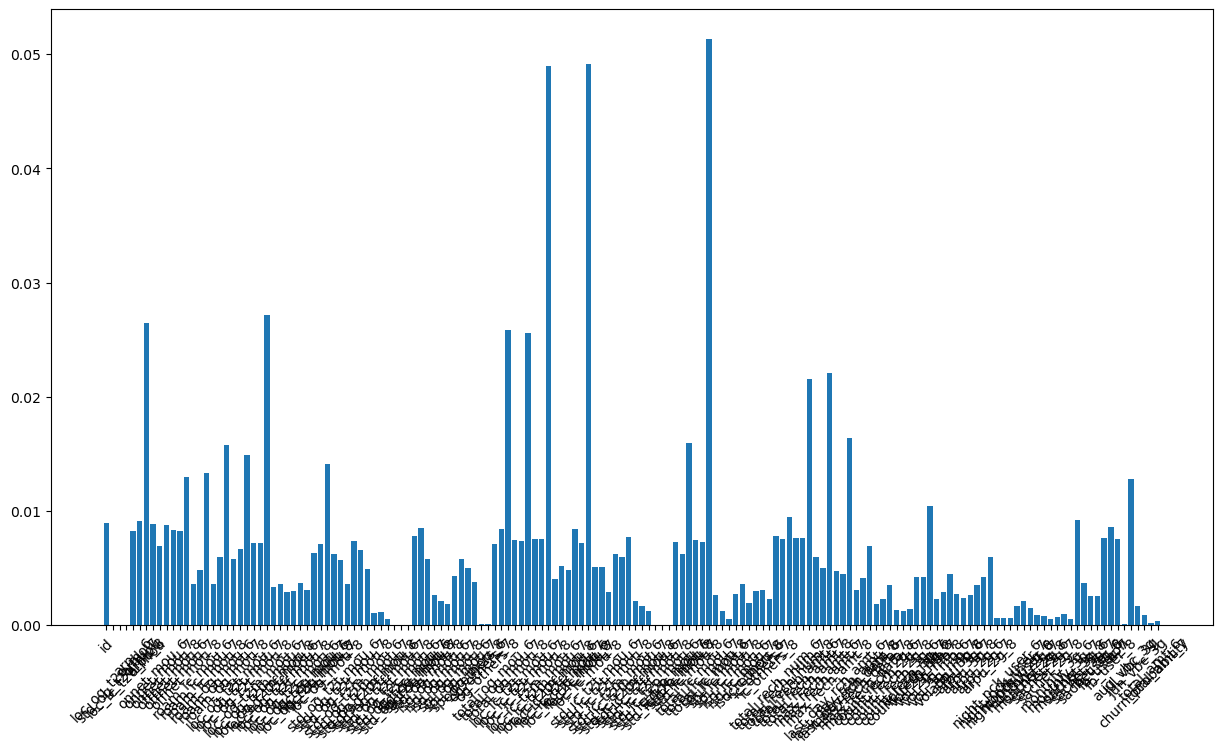

In [85]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

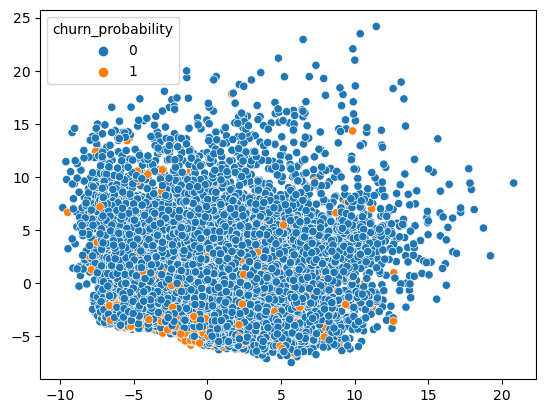

In [86]:
pca = PCA(random_state=42)
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

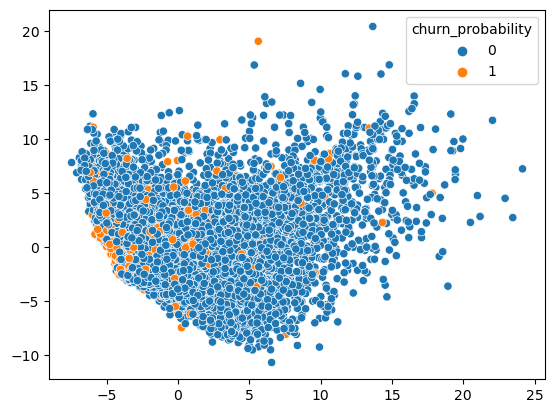

In [87]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [88]:
y_train.shape

(16373,)

In [89]:
pca_components.shape

(16373, 158)

In [90]:
rf.feature_importances_.shape

(158,)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 158 artists>

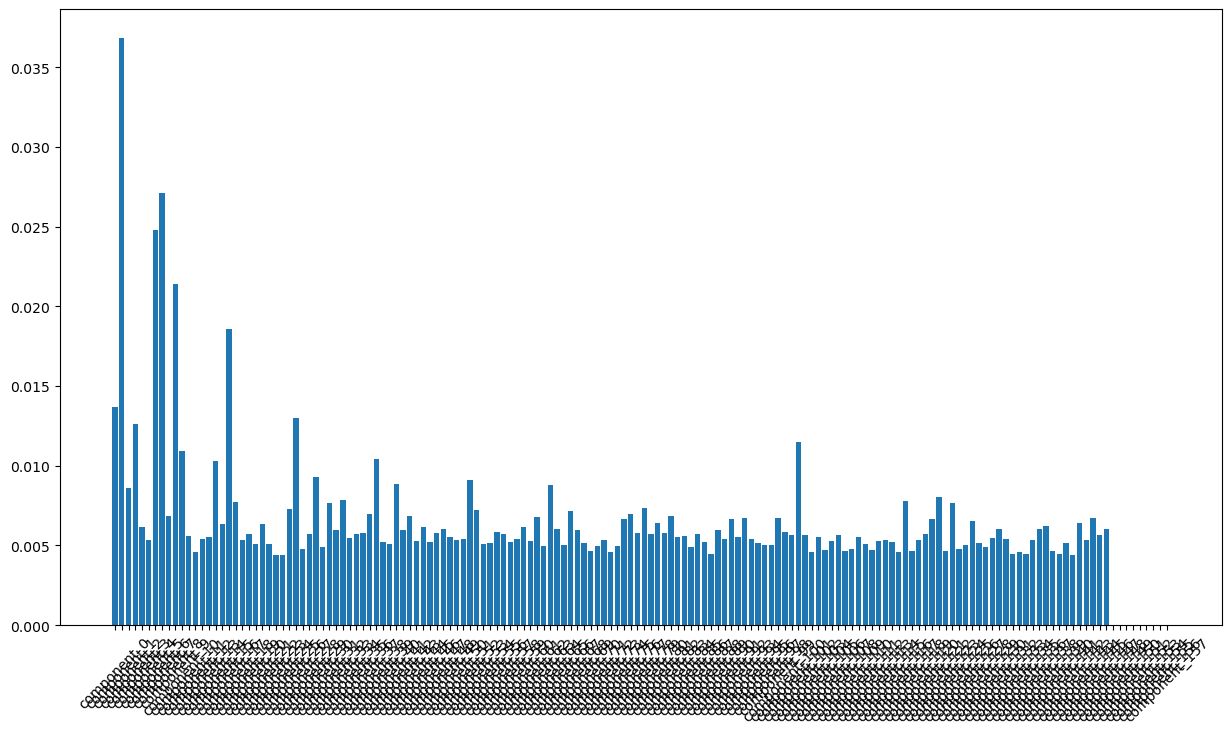

In [92]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(158)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [93]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [94]:
lr.score(pca_components[:,:2], y_train)

0.9221278934831735

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [95]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [96]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [99]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [101]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9254870823917425


In [103]:
test_score = pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9174401563263312


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [105]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[14951,   147],
       [ 1073,   202]], dtype=int64)

In [107]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[3706,   67],
       [ 271,   50]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [109]:
precision_score(y_test, pipe.predict(X_test))

0.42735042735042733

In [111]:
recall_score(y_test, pipe.predict(X_test))

0.1557632398753894

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [271]:
sample.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [272]:
unseen.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   65.330   64.445        31.78        20.23        23.11         60.16   
1  515.568  360.868        75.51        41.21        19.84        474.34   
2  434.884  746.239         7.54         7.86         8.40         16.98   
3  171.390   24.400         5.31         2.16         0.00         40.04   
4  406.289  413.329       450.93       609.03       700.68         60.94   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         32.16         34.83           0.00           0.00           0.00   
1        621.84        394.94           0.00           0.00           0.00   
2         45.81         45.04          22.81         103.38          26.08   
3        205.01         24.01           0.00           0.00           0.00   
4         23.84         74.16           0.00           0.00           0.00   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00           0.00           0.00             24.88   
1           0.00           0.00           0.00             75.51   
2          24.53          53.68          54.44              0.00   
3           0.00           0.00           0.00              5.31   
4           0.00           0.00           0.00              0.45   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             20.23             21.06             18.13             10.89   
1             41.21             19.84            473.61            598.08   
2              0.00              0.00              0.00              0.00   
3              0.00              0.00              2.94             98.61   
4              0.78             14.56              2.39              2.66   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              8.36              0.00             13.58              0.00   
1            377.26              0.73              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             20.51              0.00              0.00              2.35   
4             10.94              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0              0.00              0.03         43.01   
1               0.0              0.00              0.00        549.86   
2               0.0              0.00              0.00          0.00   
3               0.0              6.18              0.00          8.26   
4               0.0              0.00              0.00          2.84   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         44.71         29.43              6.90              0.00   
1        639.29        397.11              0.00              0.00   
2          0.00          0.00              0.00              0.00   
3         98.61         22.86              0.00              2.16   
4          3.44         25.51            450.48            608.24   

 

In [273]:
unseen.shape

(30000, 171)

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [274]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

KeyError: "['id'] not in index"

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.